# COVID-19 pandemic data analysis

### Obtain data from John Hopkins CSSE repository 

Using @GaelVaroquaux [`covid-dashboard`](https://github.com/covid19-dash/covid-dashboard) helpers

In [4]:
import sys
import matplotlib.pyplot as plt

sys.path.insert(0, "./covid-dashboard/")

In [5]:
import data_input

data = data_input.get_data()

In [6]:
data

type             confirmed                                              \
iso                    AFG    AGO     ALB     AND                  ARE   
country_region Afghanistan Angola Albania Andorra United Arab Emirates   
date                                                                     
2020-01-22               0      0       0       0                    0   
2020-01-23               0      0       0       0                    0   
2020-01-24               0      0       0       0                    0   
2020-01-25               0      0       0       0                    0   
2020-01-26               0      0       0       0                    0   
...                    ...    ...     ...     ...                  ...   
2020-04-23            1279     25     663     723                 8756   
2020-04-24            1351     25     678     731                 9281   
2020-04-25            1463     25     712     738                 9813   
2020-04-26            1531     26     726     738                10349   
2020-04-27            1703     27     736     743                10839   

type                                                                    ...  \
iso                  ARG     ARM                 ATG       AUS     AUT  ...   
country_region Argentina Armenia Antigua and Barbuda Australia Austria  ...   
date                                                                    ...   
2020-01-22             0       0                   0         0       0  ...   
2020-01-23             0       0                   0         0       0  ...   
2020-01-24             0       0                   0         0       0  ...   
2020-01-25             0       0                   0         0       0  ...   
2020-01-26             0       0                   0         4       0  ...   
...                  ...     ...                 ...       ...     ...  ...   
2020-04-23          3435    1523                  24      6662   15002  ...   
2020-04-24          3607    1596                  24      6677   15071  ...   
2020-04-25          3780    1677                  24      6694   15148  ...   
2020-04-26          3892    1746                  24      6714   15225  ...   
2020-04-27          4003    1808                  24      6721   15274  ...   

type             death                           \
iso                URY           USA        UZB   
country_region Uruguay United States Uzbekistan   
date                                              
2020-01-22           0             0          0   
2020-01-23           0             0          0   
2020-01-24           0             0          0   
2020-01-25           0             0          0   
2020-01-26           0             0          0   
...                ...           ...        ...   
2020-04-23          12         49724          7   
2020-04-24          12         51493          8   
2020-04-25          14         53755          8   
2020-04-26          15         54881          8   
2020-04-27          15         56259          8   

type                                                                     \
iso                                         VCT       VEN     VNM   YEM   
country_region Saint Vincent and the Grenadines Venezuela Vietnam Yemen   
date                                                                      
2020-01-22                                    0         0       0     0   
2020-01-23                                    0         0       0     0   
2020-01-24                                    0         0       0     0   
2020-01-25                                    0         0       0     0   
2020-01-26                                    0         0       0     0   
...                                         ...       ...     ...   ...   
2020-04-23                                    0        10       0     0   
2020-04-24                                    0        10       0     0   
2020-04-25                           

### Select countries of interest and retrieve confirmed cases and deaths dataframes

In [7]:
COUNTRIES = ["ESP", "GBR", "DEU", "AUT"]

In [8]:
confirmed = data["confirmed"][COUNTRIES]
dead = data["death"][COUNTRIES]

Text(0.5, 1.0, 'Log-scale plot of number of confirmed cases')

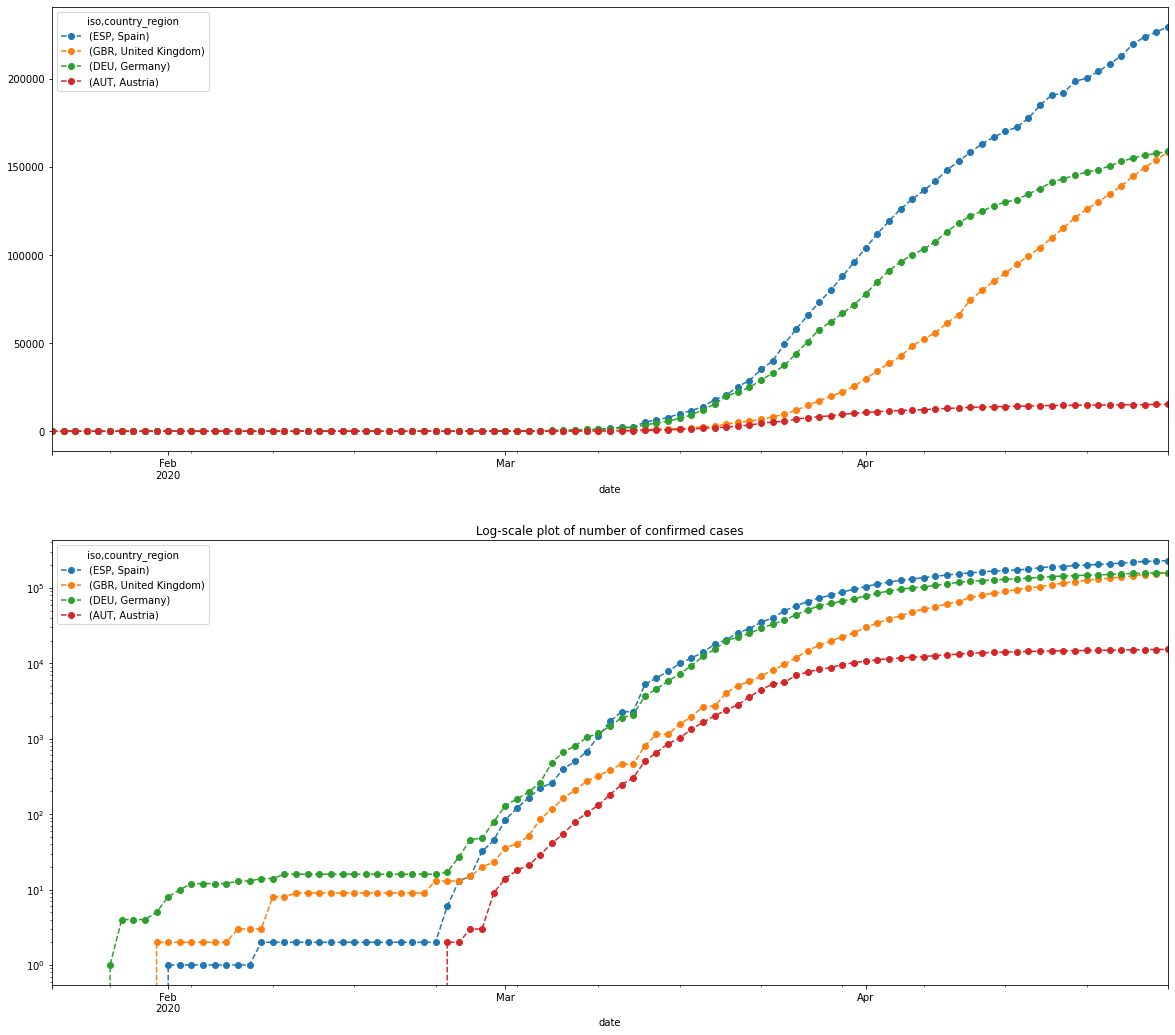

In [9]:
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(20, 18))
confirmed.plot(ax=top_ax, linestyle="--", marker="o")
confirmed.plot(ax=bottom_ax, linestyle="--", marker="o")
bottom_ax.set_yscale("log")
bottom_ax.set_title("Log-scale plot of number of confirmed cases")

Text(0.5, 1.0, 'Log-scale plot of number of total deaths (daily confirmed)')

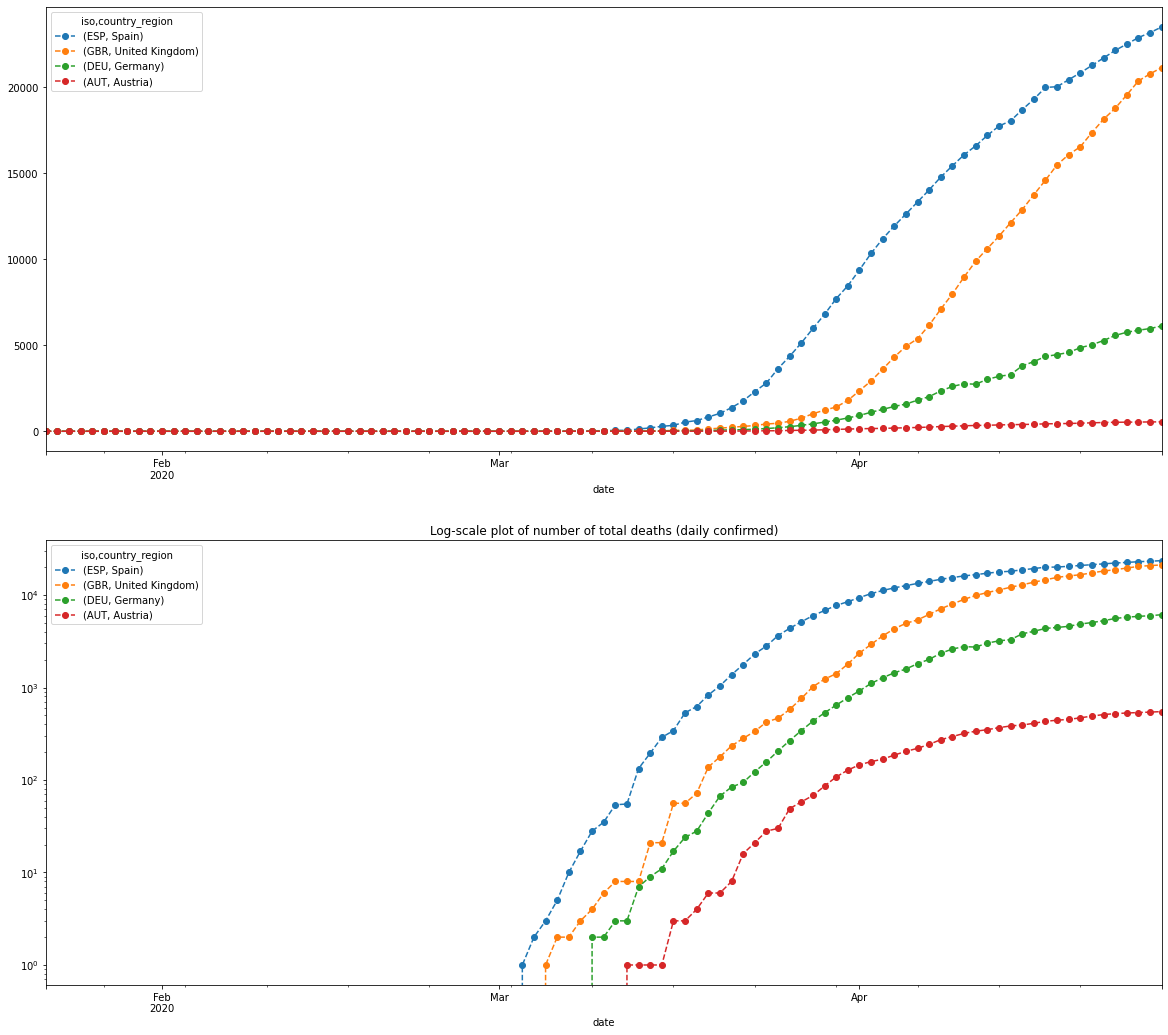

In [10]:
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(20, 18))
dead.plot(ax=top_ax, linestyle="--", marker="o")
dead.plot(ax=bottom_ax, linestyle="--", marker="o")
bottom_ax.set_yscale("log")
bottom_ax.set_title("Log-scale plot of number of total deaths (daily confirmed)")

In [11]:
# Base Data
confirmed = confirmed[["ESP", "GBR"]]
dead = dead[["ESP", "GBR"]]
last_day = confirmed.iloc[-1]
countries_of_interest = confirmed.columns[last_day.argsort()][::-1]
growth_rate = confirmed.pct_change()
abs_growth_confirmed = confirmed.diff()
abs_growth_deaths = dead.diff()

In [12]:
# Derived Data for plots
date_lockdown_ES = "2020-03-14"
date_lockdown_UK = "2020-03-23"
idx_lockdown_ES = confirmed.index.get_loc(date_lockdown_ES)
idx_lockdown_UK = confirmed.index.get_loc(date_lockdown_UK)

confirmed_on_lockdown_ES = abs_growth_confirmed["ESP"].iloc[idx_lockdown_ES]
confirmed_on_lockdown_UK = abs_growth_confirmed["GBR"].iloc[idx_lockdown_UK]

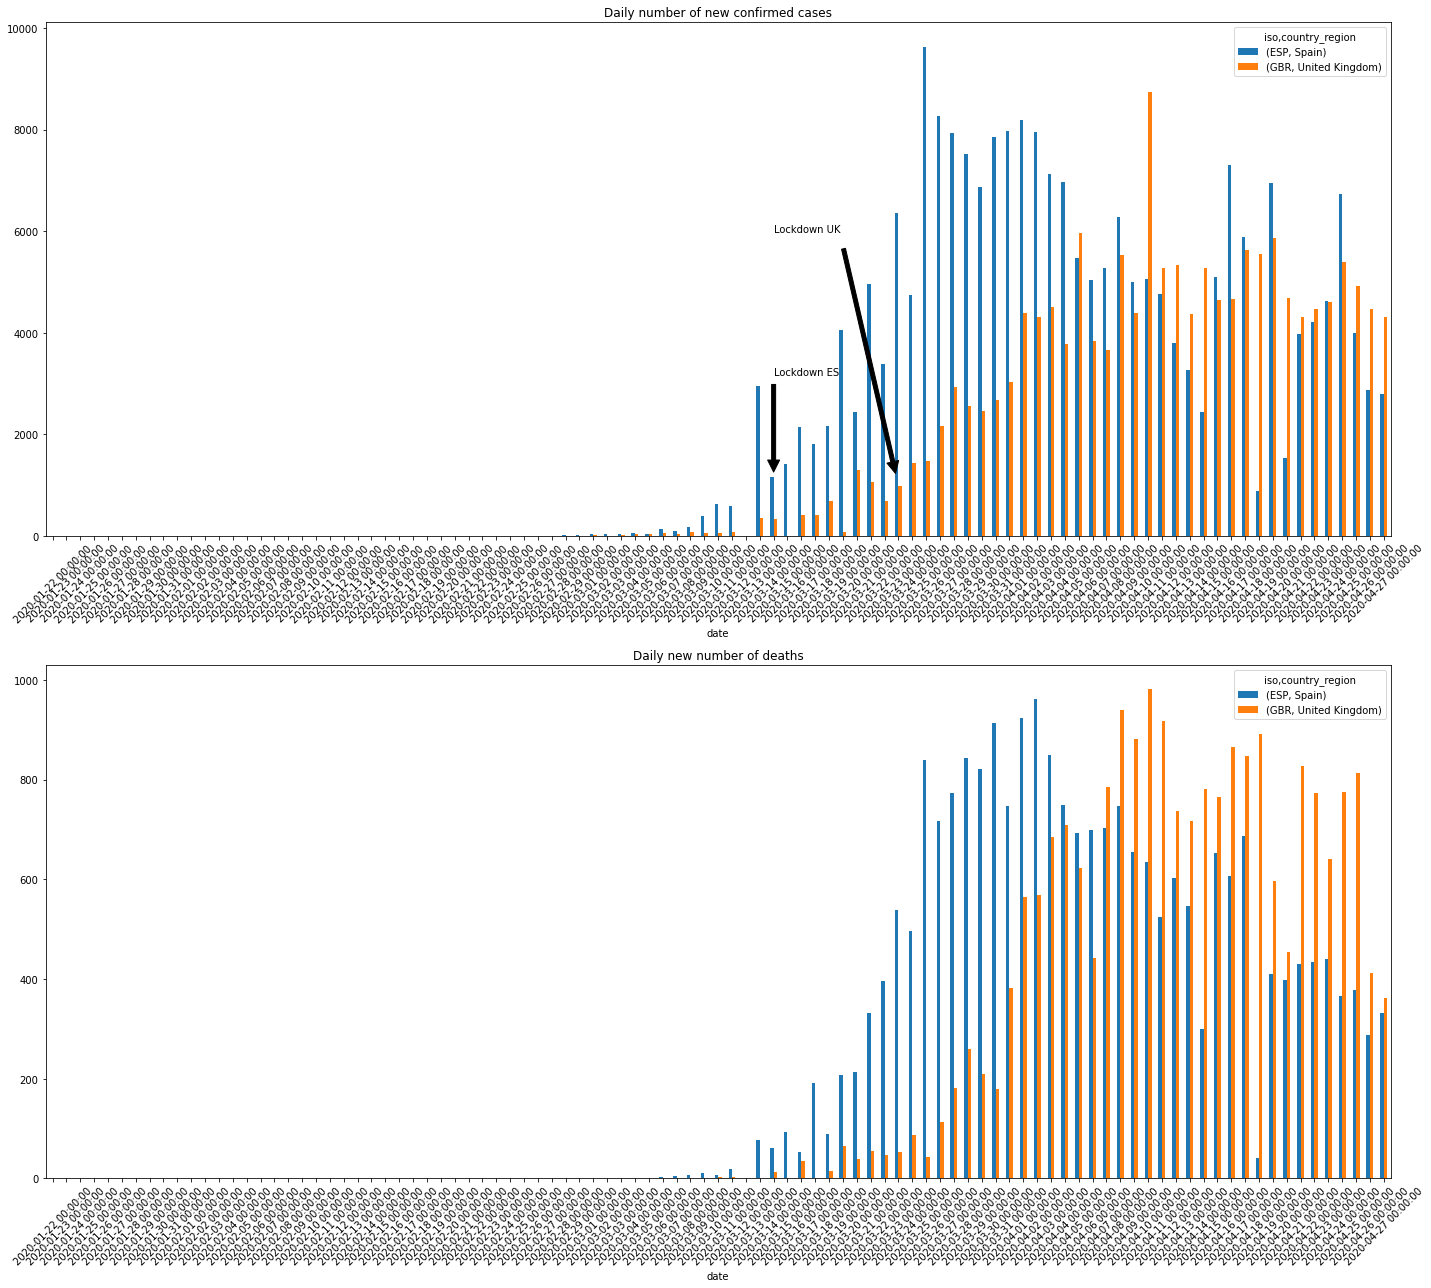

In [13]:
# Plot
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(20, 18))
abs_growth_confirmed.plot.bar(ax=top_ax, rot=45)
abs_growth_deaths.plot.bar(ax=bottom_ax, rot=45)
# plt.setp(top_ax.get_xticklabels()[::2], visible=False)
# plt.setp(bottom_ax.get_xticklabels()[::2], visible=False)
top_ax.set_title("Daily number of new confirmed cases")
top_ax.annotate(
    "Lockdown ES",
    xy=(idx_lockdown_ES, confirmed_on_lockdown_ES),
    xytext=(idx_lockdown_ES, confirmed_on_lockdown_ES + 2000),
    arrowprops=dict(facecolor="black", shrink=0.05),
)
top_ax.annotate(
    "Lockdown UK",
    xy=(idx_lockdown_UK, confirmed_on_lockdown_UK),
    xytext=(idx_lockdown_ES, confirmed_on_lockdown_UK + 5000),
    arrowprops=dict(facecolor="black", shrink=0.05),
)
bottom_ax.set_title("Daily new number of deaths")
plt.tight_layout()

## Predictive model: a simple approach

In [30]:
import numpy as np

NUM_DAYS = 17  # How many days ago, length of the window
# Build exponential weighting function


def exp_window(length=14, growth=1.1):
    window = growth ** np.arange(length)
    window = window / window.sum()
    return window

Text(0.5, 1.0, 'Weights over last 17 days.')

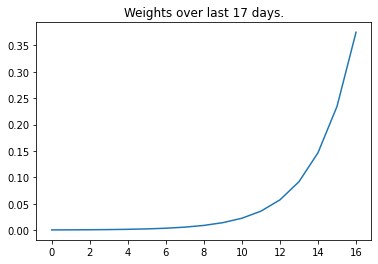

In [31]:
weighted_window = exp_window(length=NUM_DAYS, growth=1.6)
plt.figure()
plt.plot(weighted_window)
plt.title(f"Weights over last {NUM_DAYS} days.")

In [32]:
import pandas as pd

import statsmodels.api as sm

def fit_on_window(data, window):
    """ Fit the last window of the data
    """
    window_size = len(window)
    last_fortnight = data.iloc[-window_size:]
    log_last_fortnight = np.log(last_fortnight)
    log_last_fortnight[log_last_fortnight == -np.inf] = 0

    design = pd.DataFrame({'linear': np.arange(window_size),
                           'const': np.ones(window_size)})

    growth_rate = pd.DataFrame(data=np.zeros((1, len(data.columns))),
                               columns=data.columns)

    predicted_cases = pd.DataFrame()
    predicted_cases_lower = pd.DataFrame()
    predicted_cases_upper = pd.DataFrame()
    prediction_dates = pd.date_range(data.index[-window_size],
                                    periods=window_size + 7)

    for country in data.columns:
        mod_wls = sm.WLS(log_last_fortnight[country].values, design,
                         weights=window, hasconst=True)
        res_wls = mod_wls.fit()
        growth_rate[country] = np.exp(res_wls.params.linear)
        predicted_cases[country] = np.exp(res_wls.params.const +
                res_wls.params.linear * np.arange(len(prediction_dates))
            )
        # 1st and 3rd quartiles in the confidence intervals
        conf_int = res_wls.conf_int(alpha=.25)
        # We chose to account only for error in growth rate, and not in
        # baseline number of cases
        predicted_cases_lower[country] = np.exp(res_wls.params.const +
                conf_int[0].linear * np.arange(len(prediction_dates))
            )
        predicted_cases_upper[country] = np.exp(res_wls.params.const +
                conf_int[1].linear * np.arange(len(prediction_dates))
            )

    predicted_cases = pd.concat(dict(prediction=predicted_cases,
                                     lower_bound=predicted_cases_lower,
                                     upper_bound=predicted_cases_upper),
                                axis=1)
    predicted_cases['date'] = prediction_dates
    predicted_cases = predicted_cases.set_index('date')
    if window_size > 10:
        # Don't show predictions more than 10 days ago
        predicted_cases  = predicted_cases.iloc[window_size - 10:]

    return growth_rate, predicted_cases

## Cases

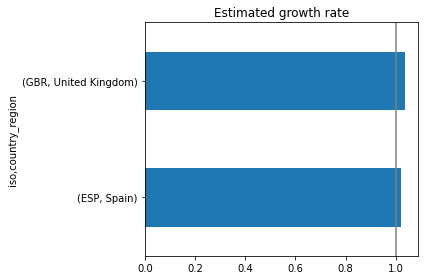

In [37]:
growth_rate, predicted_cases = fit_on_window(confirmed, weighted_window)

ax = growth_rate.T.plot(kind="barh", legend=False)
ax.set_title("Estimated growth rate")
ax.axvline(1, color=".5")
plt.tight_layout()

In [38]:
growth_rate

iso,ESP,GBR
country_region,Spain,United Kingdom
0,1.019211,1.034703


Text(0.5, 1.0, 'Number of confirmed cases in the last fortnight and prediction')

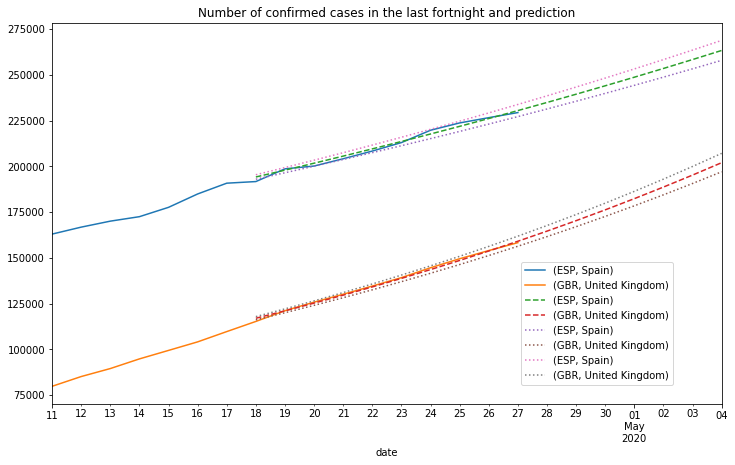

In [39]:
last_fortnight = confirmed.iloc[-NUM_DAYS:]

ax = last_fortnight[countries_of_interest].plot(figsize=(12, 7))
predicted_cases["prediction"][countries_of_interest].plot(ax=ax, style="--")
predicted_cases["lower_bound"][countries_of_interest].plot(ax=ax, style=":")
predicted_cases["upper_bound"][countries_of_interest].plot(ax=ax, style=":")

plt.legend(loc=(0.7, 0.05))
ax.set_title("Number of confirmed cases in the last fortnight and prediction")

In [40]:
predicted_cases

prediction                          lower_bound  \
             (ESP, Spain) (GBR, United Kingdom)   (ESP, Spain)   
date                                                             
2020-04-18  194222.878777         117056.804028  193003.332579   
2020-04-19  197954.188407         121118.982878  196534.283261   
2020-04-20  201757.182030         125322.130015  200129.831857   
2020-04-21  205633.236803         129671.137407  203791.160172   
2020-04-22  209583.756338         134171.066790  207519.471628   
2020-04-23  213610.171213         138827.155553  211315.991668   
2020-04-24  217713.939492         143644.822837  215181.968151   
2020-04-25  221896.547247         148629.675841  219118.671767   
2020-04-26  226159.509102         153787.516351  223127.396452   
2020-04-27  230504.368779         159124.347487  227209.459814   
2020-04-28  234932.699655         164646.380694  231366.203568   
2020-04-29  239446.105337         170360.042971  235598.993973   
2020-04-30  244046.220238         176271.984351  239909.222286   
2020-05-01  248734.710170         182389.085639  244298.305214   
2020-05-02  253513.272949         188718.466425  248767.685384   
2020-05-03  258383.639008         195267.493364  253318.831816   
2020-05-04  263347.572024         202043.788756  257953.240404   

                                    upper_bound                        
           (GBR, United Kingdom)   (ESP, Spain) (GBR, United Kingdom)  
date                                                                   
2020-04-18         116173.310201  195450.131023         117947.016794  
2020-04-19         120074.800606  199384.351970         122172.245462  
2020-04-20         124107.316178  203397.764956         126548.834952  
2020-04-21         128275.257183  207491.964040         131082.207478  
2020-04-22         132583.171663  211668.575368         135777.979495  
2020-04-23         137035.760396  215929.257817         140641.968659  
2020-04-24         141637.882032  220275.703658         145680.201029  
2020-04-25         146394.558387  224709.639225         150898.918540  
2020-04-26         151310.979929  229232.825600         156304.586729  
2020-04-27         156392.511439  233847.059315         161903.902751  
2020-04-28         161644.697865  238554.173064         167703.803674  
2020-04-29         167073.270371  243356.036434         173711.475070  
2020-04-30         172684.152597  248254.556640         179934.359926  
2020-05-01         178483.467115  253251.679291         186380.167855  
2020-05-02         184477.542116  258349.389158         193056.884655  
2020-05-03         190672.918311  263549.710964         199972.782198  
2020-05-04         197076.356072  268854.710188         207136.428684

## Fatalities

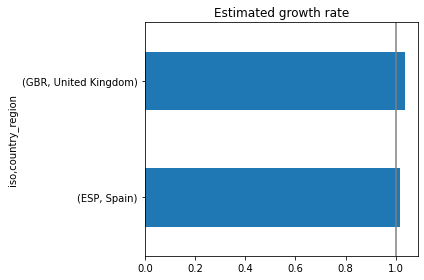

In [42]:
growth_rate, predicted_cases = fit_on_window(dead, weighted_window)

ax = growth_rate.T.plot(kind="barh", legend=False)
ax.set_title("Estimated growth rate")
ax.axvline(1, color=".5")
plt.tight_layout()

Text(0.5, 1.0, 'Number of confirmed fatalities in the last fortnight and prediction')

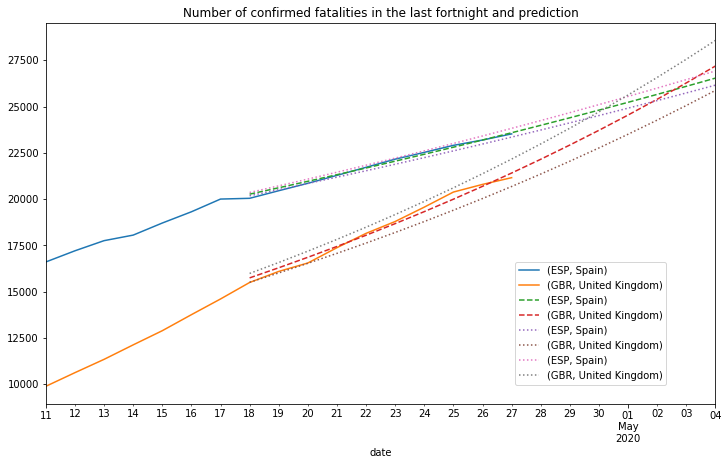

In [44]:
last_fortnight = dead.iloc[-NUM_DAYS:]

ax = last_fortnight[countries_of_interest].plot(figsize=(12, 7))
predicted_cases["prediction"][countries_of_interest].plot(ax=ax, style="--")
predicted_cases["lower_bound"][countries_of_interest].plot(ax=ax, style=":")
predicted_cases["upper_bound"][countries_of_interest].plot(ax=ax, style=":")

plt.legend(loc=(0.7, 0.05))
ax.set_title("Number of confirmed fatalities in the last fortnight and prediction")